In [1]:
%load_ext autoreload
%autoreload 2

import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, Headings
import pyEPR as epr

# 1. Create the Qbit design

In [2]:
design = designs.DesignPlanar({}, True)
design.chips.main.size['size_x'] = '2mm'
design.chips.main.size['size_y'] = '2mm'

gui = MetalGUI(design)

In [3]:
from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander

design.delete_all_components()

q1 = TransmonPocket(design, 'Q1', options = dict(
    pad_width = '425 um',
    pocket_height = '650um',
    connection_pads=dict(
        readout = dict(loc_W=+1,loc_H=+1, pad_width='200um')
    )))
otg = OpenToGround(design, 'open_to_ground', options=dict(pos_x='1.75mm',  pos_y='0um', orientation='0'))
readout = RouteMeander(design, 'readout',  Dict(
            total_length='6 mm',
            hfss_wire_bonds = True,
            fillet='90 um',
            lead = dict(start_straight='100um'),
            pin_inputs=Dict(
                start_pin=Dict(component='Q1', pin='readout'),
                end_pin=Dict(component='open_to_ground', pin='open')), ))

gui.rebuild()
gui.autoscale()

# 2. Analyze the transmon & resonator using the Eigenmode-EPR method

In [4]:
from qiskit_metal.analyses.quantization import EPRanalysis
eig_qres = EPRanalysis(design, "hfss")

In [5]:
hfss = eig_qres.sim.renderer

In [9]:
hfss.start()

INFO 10:56AM [connect_project]: Connecting to Ansys Desktop API...
INFO 10:56AM [load_ansys_project]: 	Opened Ansys App
INFO 10:56AM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 10:56AM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/Airplane/OneDrive - skku.edu/문서/Ansoft/
	Project:   Tutorial_Q+Res_EPR&LOM
INFO 10:56AM [connect_design]: 	Opened active design
	Design:    TransmonReadout [Solution type: Eigenmode]
INFO 10:56AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 10:56AM [connect]: 	Connected to project "Tutorial_Q+Res_EPR&LOM" and design "TransmonReadout" 😀 



True

In [7]:
hfss.activate_ansys_design("TransmonReadout", 'eigenmode')

10:54AM 17s WARNING [activate_ansys_design]: The design_name=TransmonReadout was not in active project.  Designs in active project are: 
[].  A new design will be added to the project.  
INFO 10:54AM [connect_design]: 	Opened active design
	Design:    TransmonReadout [Solution type: Eigenmode]
WARNING 10:54AM [connect_setup]: 	No design setup detected.
WARNING 10:54AM [connect_setup]: 	Creating eigenmode default setup.
INFO 10:54AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [8]:
hfss.render_design(['Q1', 'readout', 'open_to_ground'], [])
hfss.save_screenshot()

com_error: (-2147023170, '원격 프로시저를 호출하지 못했습니다.', None, None)

In [ ]:
# Analysis properties
setup = hfss.pinfo.setup
setup.n_modes = 2
setup.passes = 10
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
pinfo.design.set_variable('Lj', '10 nH')
pinfo.design.set_variable('Cj', '0 fF')

In [17]:
eig_qres.sim.close()

In [20]:
hfss.start()

INFO 10:49AM [connect_project]: Connecting to Ansys Desktop API...
INFO 10:49AM [load_ansys_project]: 	Opened Ansys App
INFO 10:49AM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 10:49AM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/Airplane/OneDrive - skku.edu/문서/Ansoft/
	Project:   Tutorial_afterPR
INFO 10:49AM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:49AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:49AM [connect]: 	Connected to project "Tutorial_afterPR" and design "Design_q3d" 😀 



True

In [14]:
eig_qres.sim.convergence_t, eig_qres.sim.convergence_f, _ = hfss.get_convergences()
eig_qres.sim.plot_convergences()

10:20AM 22s INFO [get_f_convergence]: Saved convergences to C:\Users\Airplane\JupyterProject\hfss_eig_f_convergence.csv


# field of mode 1

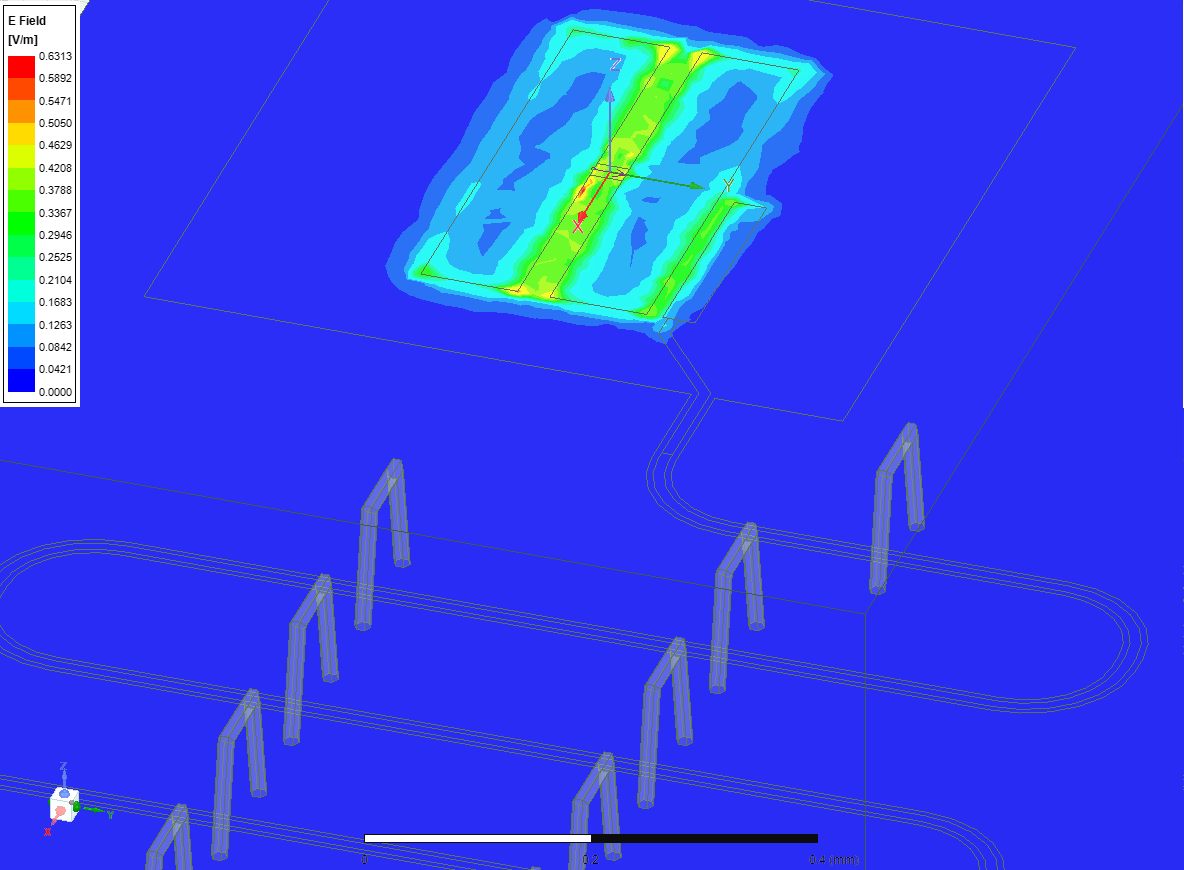

WindowsPath('C:/Users/Airplane/JupyterProject/ansys.png')

In [15]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_fields('main')
hfss.save_screenshot()

# field of mode2

In [10]:
hfss.set_mode(2, "Setup")

INFO 10:57AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


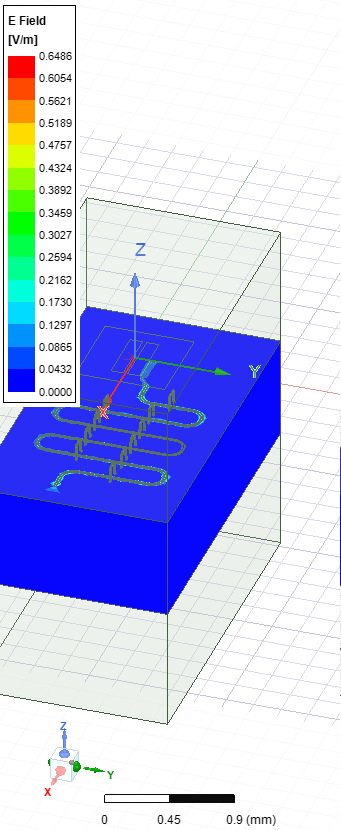

WindowsPath('C:/Users/Airplane/JupyterProject/ansys.png')

In [11]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_fields('main')
hfss.save_screenshot()

In [14]:
hfss.clear_fields(['Mag_E1_2'])

# EPR Analysis

In [15]:
pinfo = hfss.pinfo
pinfo.junctions['jj'] = {'Lj_variable': 'Lj', 'rect': 'JJ_rect_Lj_Q1_rect_jj',
                             'line': 'JJ_Lj_Q1_rect_jj_',  'Cj_variable': 'Cj'}
pinfo.validate_junction_info() # Check that valid names of variables and objects have been supplied
pinfo.dissipative['dielectrics_bulk'] = ['main'] # Dissipative elements: specify

In [16]:
eprd = epr.DistributedAnalysis(pinfo)

Design "TransmonReadout" info:
	# eigenmodes    2
	# variations    1


In [17]:
ℰ_elec = eprd.calc_energy_electric()
ℰ_elec_substrate = eprd.calc_energy_electric(None, 'main')
ℰ_mag = eprd.calc_energy_magnetic()

print(f"""
ℰ_elec_all       = {ℰ_elec}
ℰ_elec_substrate = {ℰ_elec_substrate}
EPR of substrate = {ℰ_elec_substrate / ℰ_elec * 100 :.1f}%

ℰ_mag_all       = {ℰ_mag}
ℰ_mag % of ℰ_elec_all  = {ℰ_mag / ℰ_elec * 100 :.1f}%
""")


ℰ_elec_all       = 2.9673473800741e-24
ℰ_elec_substrate = 2.70875568508489e-24
EPR of substrate = 91.3%

ℰ_mag_all       = 2.95902409173237e-24
ℰ_mag % of ℰ_elec_all  = 99.7%



In [18]:
eprd.do_EPR_analysis()

# 4a. Perform Hamiltonian spectrum post-analysis, building on mw solutions using EPR
epra = epr.QuantumAnalysis(eprd.data_filename)
epra.analyze_all_variations(cos_trunc = 8, fock_trunc = 7)

# 4b. Report solved results
swp_variable = 'Lj' # suppose we swept an optimetric analysis vs. inductance Lj_alice
epra.plot_hamiltonian_results(swp_variable=swp_variable)
epra.report_results(swp_variable=swp_variable, numeric=True)


Variation 0  [1/1]

  Mode 0 at 6.17 GHz   [1/2]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.2%  4.345e-24 3.454e-26

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 97.08%
	jj              0.991626  (+)        0.0298118
		(U_tot_cap-U_tot_ind)/mean=1.49%
Calculating Qdielectric_main for mode 0 (0/1)
p_dielectric_main_0 = 0.9139364004783898

  Mode 1 at 9.36 GHz   [2/2]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
                0.3%  1.484e-24  1.48e-24

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_1j   sign s_1j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 93.53%
	jj              0.0028101  (+)        0.000194349
		(U_tot_cap-U_tot_ind)/mean=0.01%
Calculating Qdielectric_

WARNING 11:02AM [__init__]: <p>Error: <class 'IndexError'></p>



ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Tutorial_Q+Res_EPR&LOM\TransmonReadout\2021-09-30 11-01-30.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.030372
1    1.033763
dtype: float64

Pm_norm idx =
      jj
0   True
1  False
*** P (participation matrix, not normlz.)
         jj
0  0.962919
1  0.002810

*** S (sign-bit matrix)
   s_jj
0     1
1     1
*** P (participation matrix, normalized.)
      0.99
    0.0028

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       287     2.46
      2.46  0.00529

*** Chi matrix ND (MHz) 
       319     2.12
      2.12  0.00392

*** Frequencies O1 PT (MHz)
0    5882.718402
1    9357.886855
dtype: float64

*** Frequencies ND (MHz)
0    5867.564505
1    9357.932315
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj,10
eigenmode,
0,5882.72
1,9357.89


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

0         1
Lj                    
10 0  318.82  2.12e+00
   1    2.12  3.92e-03

# 3. Analyze the transmon using the LOM method

In [19]:
from qiskit_metal.analyses.quantization import LOManalysis
c2 = LOManalysis(design, "q3d")

In [20]:
q3d = c2.sim.renderer

In [21]:
q3d.start()

INFO 11:03AM [connect_project]: Connecting to Ansys Desktop API...
INFO 11:03AM [load_ansys_project]: 	Opened Ansys App
INFO 11:03AM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 11:03AM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/Airplane/OneDrive - skku.edu/문서/Ansoft/
	Project:   Tutorial_Q+Res_EPR&LOM
INFO 11:03AM [connect_design]: 	Opened active design
	Design:    TransmonReadout [Solution type: Eigenmode]
INFO 11:03AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 11:03AM [connect]: 	Connected to project "Tutorial_Q+Res_EPR&LOM" and design "TransmonReadout" 😀 



True

In [22]:
q3d.activate_ansys_design("TransmonResonator_q3d", 'capacitive')

11:03AM 45s WARNING [activate_ansys_design]: The design_name=TransmonResonator_q3d was not in active project.  Designs in active project are: 
['TransmonReadout'].  A new design will be added to the project.  
INFO 11:03AM [connect_design]: 	Opened active design
	Design:    TransmonResonator_q3d [Solution type: Q3D]
WARNING 11:03AM [connect_setup]: 	No design setup detected.
WARNING 11:03AM [connect_setup]: 	Creating Q3D default setup.
INFO 11:03AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)


In [23]:
q3d.render_design(['Q1'], [('Q1','readout')])

In [26]:
q3d.close()

Warning! 3 COM references still alive
Ansys will likely refuse to shut down


True

In [27]:
q3d.start()

INFO 11:08AM [connect_project]: Connecting to Ansys Desktop API...
INFO 11:08AM [load_ansys_project]: 	Opened Ansys App
INFO 11:08AM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 11:08AM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/Airplane/OneDrive - skku.edu/문서/Ansoft/
	Project:   Tutorial_Q+Res_EPR&LOM
INFO 11:08AM [connect_design]: 	Opened active design
	Design:    TransmonResonator_q3d [Solution type: Q3D]
INFO 11:08AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 11:08AM [connect]: 	Connected to project "Tutorial_Q+Res_EPR&LOM" and design "TransmonResonator_q3d" 😀 



True

In [28]:
c2.sim.capacitance_matrix, c2.sim.units = q3d.get_capacitance_matrix()
c2.sim.capacitance_all_passes, _ = q3d.get_capacitance_all_passes()
c2.sim.capacitance_matrix

INFO 11:08AM [get_matrix]: Exporting matrix data to (C:\Users\Airplane\AppData\Local\Temp\tmpi_51cpui.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 11:08AM [get_matrix]: Exporting matrix data to (C:\Users\Airplane\AppData\Local\Temp\tmp5k199ti7.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 11:08AM [get_matrix]: Exporting matrix data to (C:\Users\Airplane\AppData\Local\Temp\tmpvl_fzge8.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 11:08AM [get_matrix]: Exporting matrix data to (C:\Users\Airplane\AppData\Local\Temp\tmp7jeaeg5f.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 3, False
INFO 11:08AM [get_matrix]: Exporting matrix data to (C:\Users\Airplane\AppData\Local\Temp\tmpm1pxblk1.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 4, F

,ground_main_plane,pad_bot_Q1,pad_top_Q1,readout_connector_pad_Q1
ground_main_plane,177.78538,-44.74611,-38.34722,-37.03041
pad_bot_Q1,-44.74611,82.84141,-32.48515,-2.30760
pad_top_Q1,-38.34722,-32.48515,93.38943,-19.67329
readout_connector_pad_Q1,-37.03041,-2.30760,-19.67329,60.14998


# LOM Analysis

In [29]:
c2.setup.junctions=Dict(Lj=12.31, Cj=2)
c2.setup.freq_readout = 7.0
c2.setup.freq_bus = []

c2.run_lom()
c2.lumped_oscillator_all

INFO 11:09AM [__del__]: Disconnected from Ansys HFSS
INFO 11:09AM [__del__]: Disconnected from Ansys HFSS


[1, 2] [3]
Predicted Values

Transmon Properties
f_Q 5.492369 [GHz]
EC 320.340887 [MHz]
EJ 13.273404 [GHz]
alpha -374.552102 [MHz]
dispersion 58.767574 [KHz]
Lq 12.305036 [nH]
Cq 60.467548 [fF]
T1 47.110126 [us]

**Coupling Properties**

tCqbus1 -7.535751 [fF]
gbus1_in_MHz -119.111599 [MHz]
χ_bus1 -3.815566 [MHz]
1/T1bus1 3378.359561 [Hz]
T1bus1 47.110126 [us]
Bus-Bus Couplings


,fQ,EC,EJ,alpha,dispersion,gbus,chi_in_MHz,χr MHz,gr MHz
1,5.848077,366.598874,13.273404,-435.018704,183.524692,[-120.90670176407029],[-7.037262053036213],7.037262,120.906702
2,5.800483,360.198512,13.273404,-426.553995,158.893606,[-112.5714316750082],[-5.610863434478079],5.610863,112.571432
3,5.728978,350.706154,13.273404,-414.05886,127.373567,[-114.4721344200509],[-5.13583772345763],5.135838,114.472134
4,5.645726,339.839946,13.273404,-399.840701,97.757395,[-113.75236108111946],[-4.422671613573631],4.422672,113.752361
5,5.574615,330.715418,13.273404,-387.971176,77.483483,[-115.42485160814473],[-4.067027529551065],4.067028,115.424852
6,5.552051,327.850119,13.273404,-384.256913,71.883362,[-116.90656488361248],[-4.027920633489713],4.027921,116.906565
7,5.522295,324.093652,13.273404,-379.396816,65.050231,[-118.53068129631139],[-3.9548493935624265],3.954849,118.530681
8,5.508895,322.410099,13.273404,-377.222089,62.166575,[-118.93049750280109],[-3.9007913880709433],3.900791,118.930498
9,5.492369,320.340887,13.273404,-374.552102,58.767574,[-119.11159900747404],[-3.8155660691693987],3.815566,119.111599


In [30]:
c2.plot_convergence();
c2.plot_convergence_chi()

INFO 11:09AM [hfss_report_full_convergence]: Creating report for variation 0


Design "TransmonResonator_q3d" info:
	# eigenmodes    0
	# variations    1


INFO 11:09AM [__del__]: Disconnected from Ansys HFSS


In [31]:
c2.sim.close()

Warning! 3 COM references still alive
Ansys will likely refuse to shut down
